In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.decomposition import PCA

In [12]:
def train_and_evaluate_on_datasets(datasets, model_name):
    model_map = {
        'logistic': LogisticRegression(max_iter=1000, random_state=42),
        'svm': SVC(kernel='rbf', probability=True, random_state=42),
        'random_forest': RandomForestClassifier(random_state=42),
        'catboost': CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0),
        'xgboost': XGBClassifier(
            eval_metric='logloss',
            random_state=42),
    }

    if model_name not in model_map:
        raise ValueError(f"Unsupported model: {model_name}")

    model = model_map[model_name]
    num_datasets = len(datasets)
    fig, axes = plt.subplots(nrows=num_datasets, ncols=2, figsize=(12, 5 * num_datasets))
    if num_datasets == 1:
        axes = [axes]  # Make it iterable

    for idx, data in enumerate(datasets):
        # Determine dataset title for display
        if hasattr(data, 'name') and data.name:
            dataset_title = data.name
        elif isinstance(data, pd.DataFrame) and hasattr(data, 'attrs') and 'title' in data.attrs:
            dataset_title = data.attrs['title']
        else:
            dataset_title = f"Dataset {idx+1}"
        
        data = data.drop(columns=['VariantLabel']) if 'VariantLabel' in data.columns else data
        model_ids = data['ModelID'] if 'ModelID' in data.columns else None
        data = data.drop(columns=['ModelID']) if 'ModelID' in data.columns else data
        features = data.drop(columns=['Mutated', 'VariantType'])
        target = data['Mutated']

        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # CatBoost and XGBoost don't need feature scaling
        if model_name in ['catboost', 'xgboost']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

        print(f"{dataset_title} - Accuracy: {acc:.2f} - F1 Score: {f1:.2f} - Model: {model_name}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx][0])
        axes[idx][0].set_title(f'{dataset_title} - Confusion Matrix')
        axes[idx][0].set_xlabel('Predicted')
        axes[idx][0].set_ylabel('True')

        # Feature importance
        if model_name in ['random_forest', 'catboost', 'xgboost']:
            importances = model.feature_importances_
        elif model_name in ['svm', 'logistic']:
            if hasattr(model, 'coef_'):
                importances = np.abs(model.coef_).flatten()
            else:
                axes[idx][1].axis('off')
                continue
        else:
            axes[idx][1].axis('off')
            continue

        indices = np.argsort(importances)[::-1][:10]
        top_features = features.columns[indices]
        sns.barplot(x=importances[indices], y=top_features, ax=axes[idx][1])
        axes[idx][1].set_title(f'Dataset {idx+1} - Feature Importance')

    plt.tight_layout()
    plt.show()

In [13]:
dataset_1 = pd.read_csv('../data/processed/ccle_quantile_filtered.csv').drop(columns=['VariantLabel'])
dataset_2 = pd.read_csv('../data/processed/ccle_tp53_filtered.csv').drop(columns=['VariantLabel'])
dataset_3 = pd.read_csv('../data/processed/ccle_variance_filtered.csv').drop(columns=['VariantLabel'])
dataset_4 = pd.read_csv('../data/processed/merged_data.csv', index_col= 1).drop(columns=['Unnamed: 0'], errors='ignore')

dataset_1.name = "Quantile Filtered"
dataset_2.name = "TP53 Filtered"
dataset_3.name = "Variance Filtered"
dataset_4.name = "Not Filtered"
datasets = [dataset_4, dataset_1, dataset_2, dataset_3]

In [14]:
def plot_pca_class_separation(data, target_column='Mutated', use_columns=None, custom_labels=None):
    """
    Plots 2D class separation using PCA or specified columns.
    
    Parameters:
        data (pd.DataFrame): Input dataframe.
        target_column (str): Name of the label/target column.
        use_columns (list or None): If specified, uses these two columns instead of PCA.
        custom_labels (array-like or None): Optional custom labels to override the target column.
    """
    # Drop unused columns
    data = data.drop(columns=['VariantLabel', 'ModelID'], errors='ignore')

    # Use custom labels if provided
    target = custom_labels if custom_labels is not None else data[target_column]

    # If specific columns are passed, use them
    if use_columns is not None:
        if len(use_columns) != 2:
            raise ValueError("use_columns must be a list of two column names.")
        pca_df = data[use_columns].copy()
        pca_df.columns = ['PC1', 'PC2']
    else:
        # Extract features excluding target and other known non-feature columns
        features = data.drop(columns=[target_column, 'VariantType'], errors='ignore')
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(features)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

    # Add target for plotting
    pca_df['label'] = target.values if hasattr(target, 'values') else target

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette='Set1', s=60, edgecolor='k')
    plt.title('2D Class Separation')
    plt.xlabel('Principal Component 1' if use_columns is None else use_columns[0])
    plt.ylabel('Principal Component 2' if use_columns is None else use_columns[1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

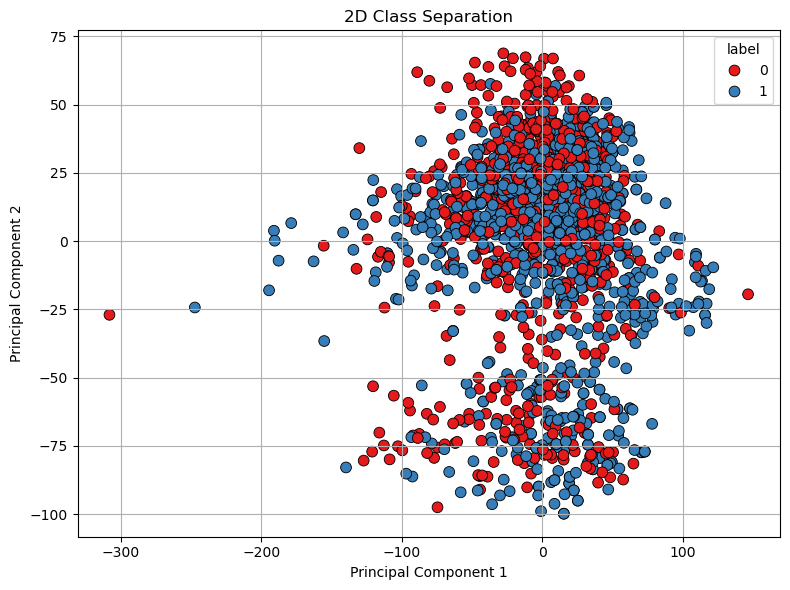

In [15]:
plot_pca_class_separation(datasets[0])

# Random baseline

Random Guessing - Accuracy: 0.51 - F1 Score: 0.52


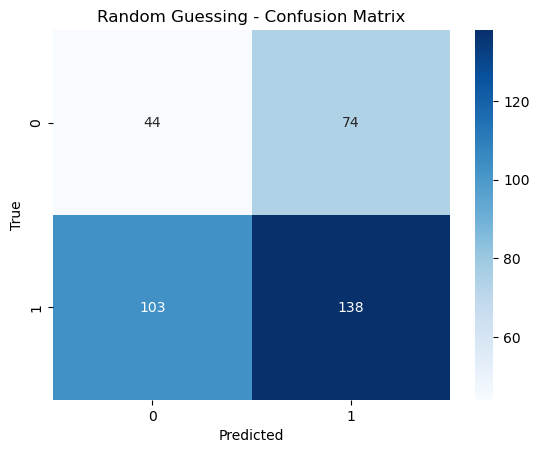

In [16]:
# Random guessing baseline for dataset_3
def random_guessing_baseline(data, target_column='Mutated'):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Drop unused columns
    data = data.drop(columns=['VariantLabel', 'ModelID'], errors='ignore')
    features = data.drop(columns=[target_column, 'VariantType'], errors='ignore')
    target = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Randomly guess according to the class distribution in the train set
    class_probs = y_train.value_counts(normalize=True).sort_index().values
    classes = np.sort(y_train.unique())
    y_pred = np.random.choice(classes, size=len(y_test), p=class_probs)

    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    print(f"Random Guessing - Accuracy: {acc:.2f} - F1 Score: {f1:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Guessing - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

random_guessing_baseline(dataset_4)

# Logistic

Not Filtered - Accuracy: 0.84 - F1 Score: 0.84 - Model: logistic
Quantile Filtered - Accuracy: 0.85 - F1 Score: 0.85 - Model: logistic
TP53 Filtered - Accuracy: 0.84 - F1 Score: 0.83 - Model: logistic
Quantile Filtered - Accuracy: 0.85 - F1 Score: 0.85 - Model: logistic
TP53 Filtered - Accuracy: 0.84 - F1 Score: 0.83 - Model: logistic
Variance Filtered - Accuracy: 0.84 - F1 Score: 0.84 - Model: logistic
Variance Filtered - Accuracy: 0.84 - F1 Score: 0.84 - Model: logistic


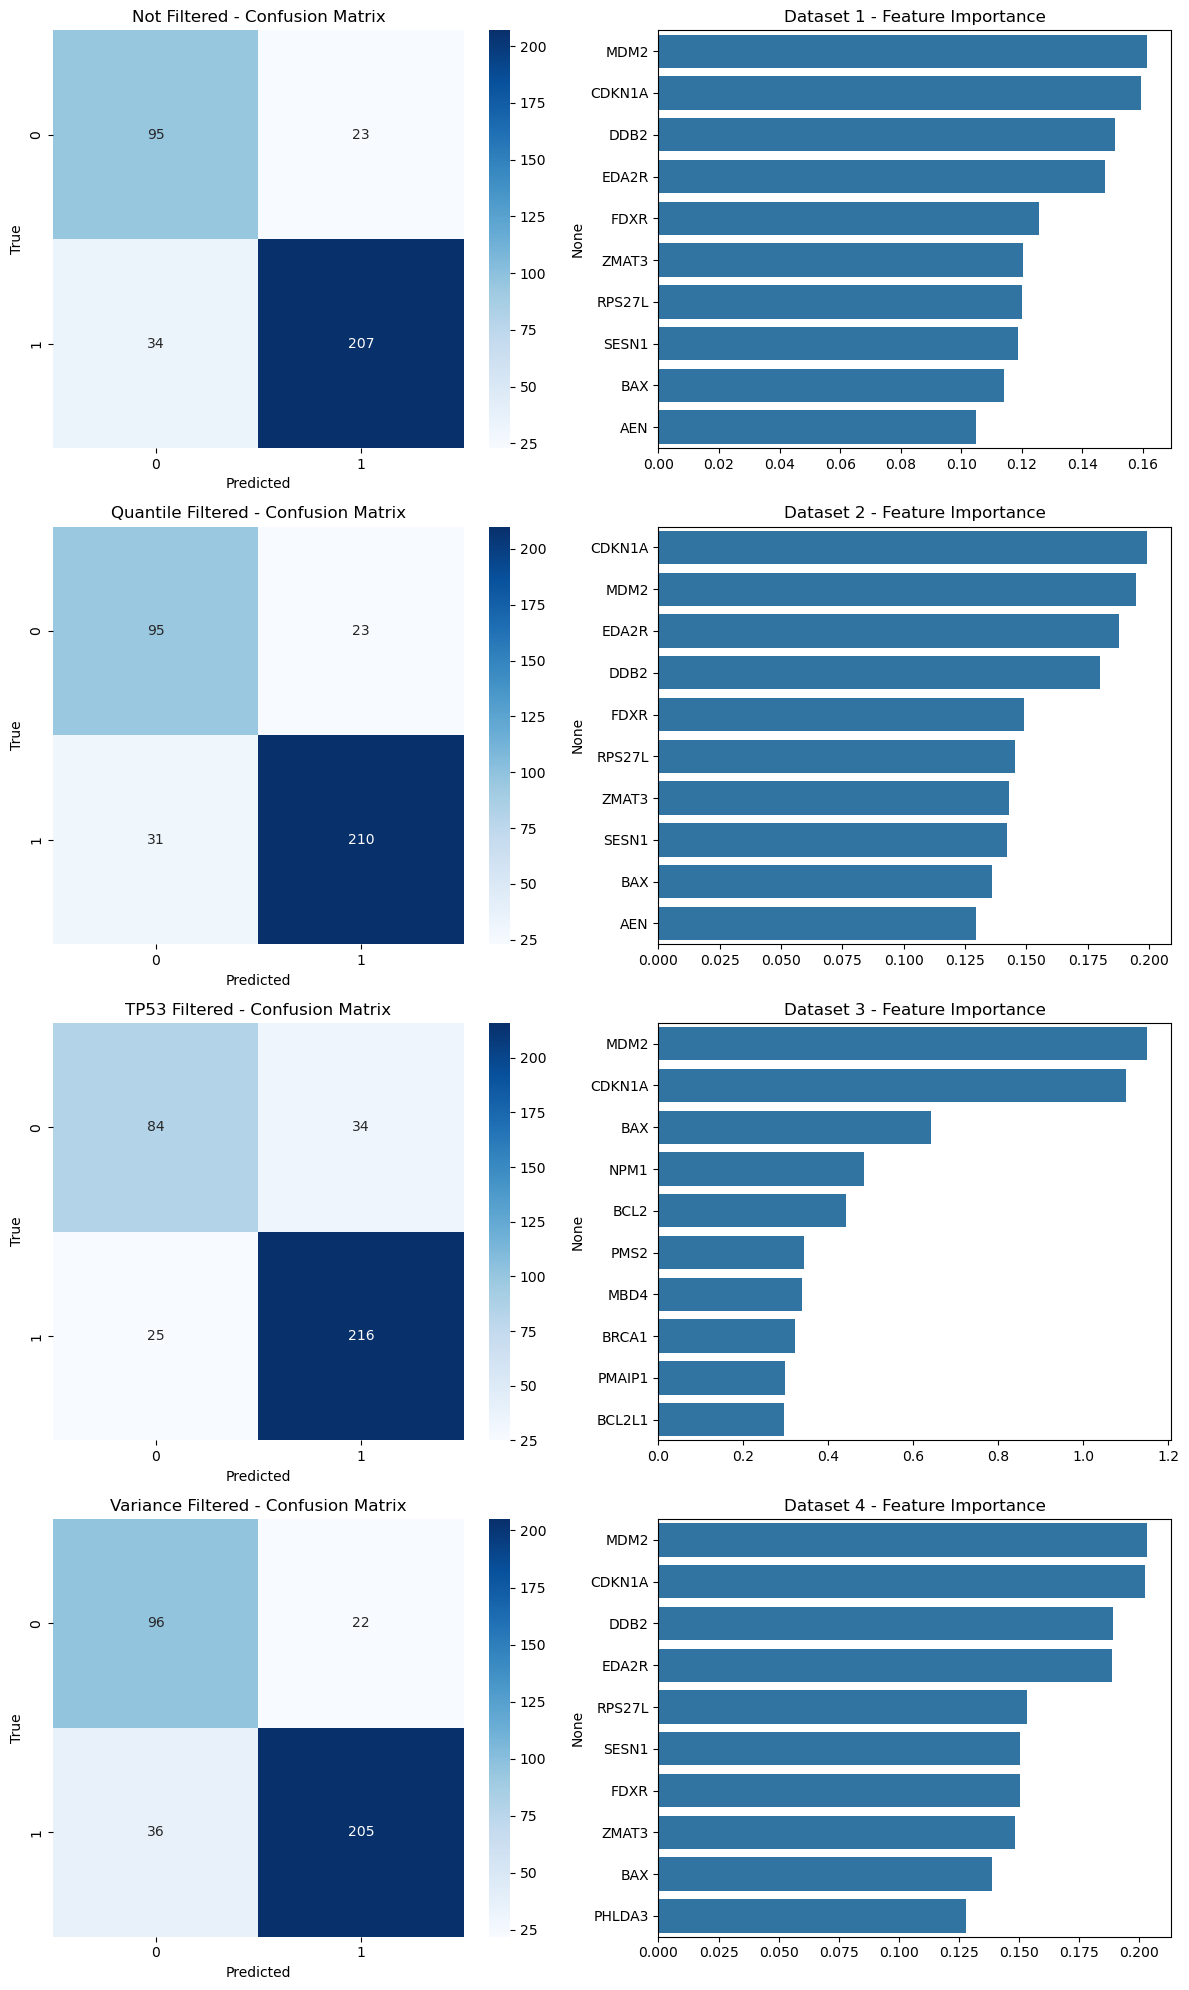

In [17]:
train_and_evaluate_on_datasets(datasets, 'logistic')

# SVM

Not Filtered - Accuracy: 0.86 - F1 Score: 0.86 - Model: svm
Quantile Filtered - Accuracy: 0.86 - F1 Score: 0.86 - Model: svm
TP53 Filtered - Accuracy: 0.87 - F1 Score: 0.87 - Model: svm
Variance Filtered - Accuracy: 0.87 - F1 Score: 0.87 - Model: svm


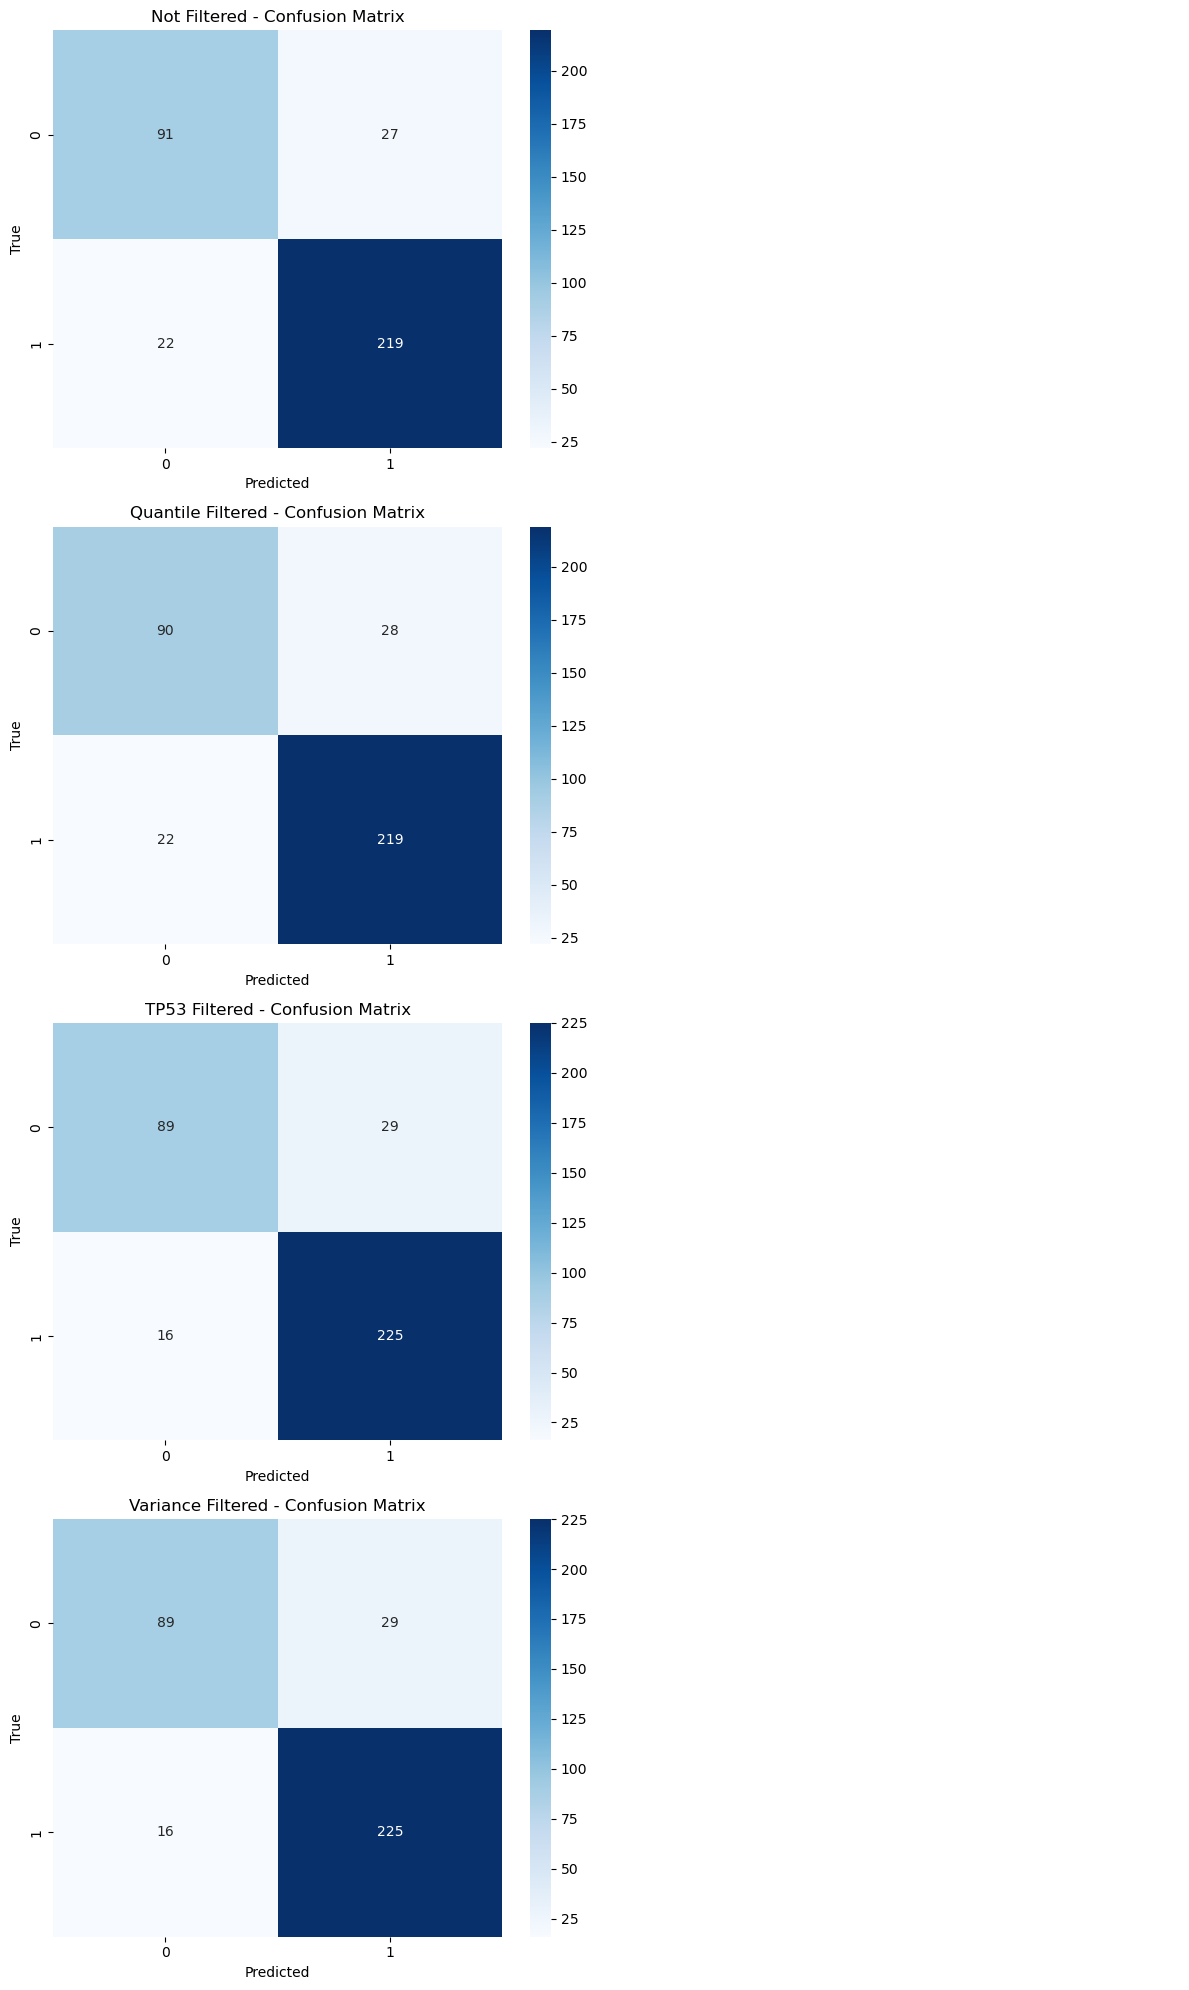

In [18]:
train_and_evaluate_on_datasets(datasets, 'svm')

# RandomForest

Not Filtered - Accuracy: 0.86 - F1 Score: 0.86 - Model: random_forest
Quantile Filtered - Accuracy: 0.86 - F1 Score: 0.86 - Model: random_forest
Quantile Filtered - Accuracy: 0.86 - F1 Score: 0.86 - Model: random_forest
TP53 Filtered - Accuracy: 0.87 - F1 Score: 0.86 - Model: random_forest
TP53 Filtered - Accuracy: 0.87 - F1 Score: 0.86 - Model: random_forest
Variance Filtered - Accuracy: 0.87 - F1 Score: 0.86 - Model: random_forest
Variance Filtered - Accuracy: 0.87 - F1 Score: 0.86 - Model: random_forest


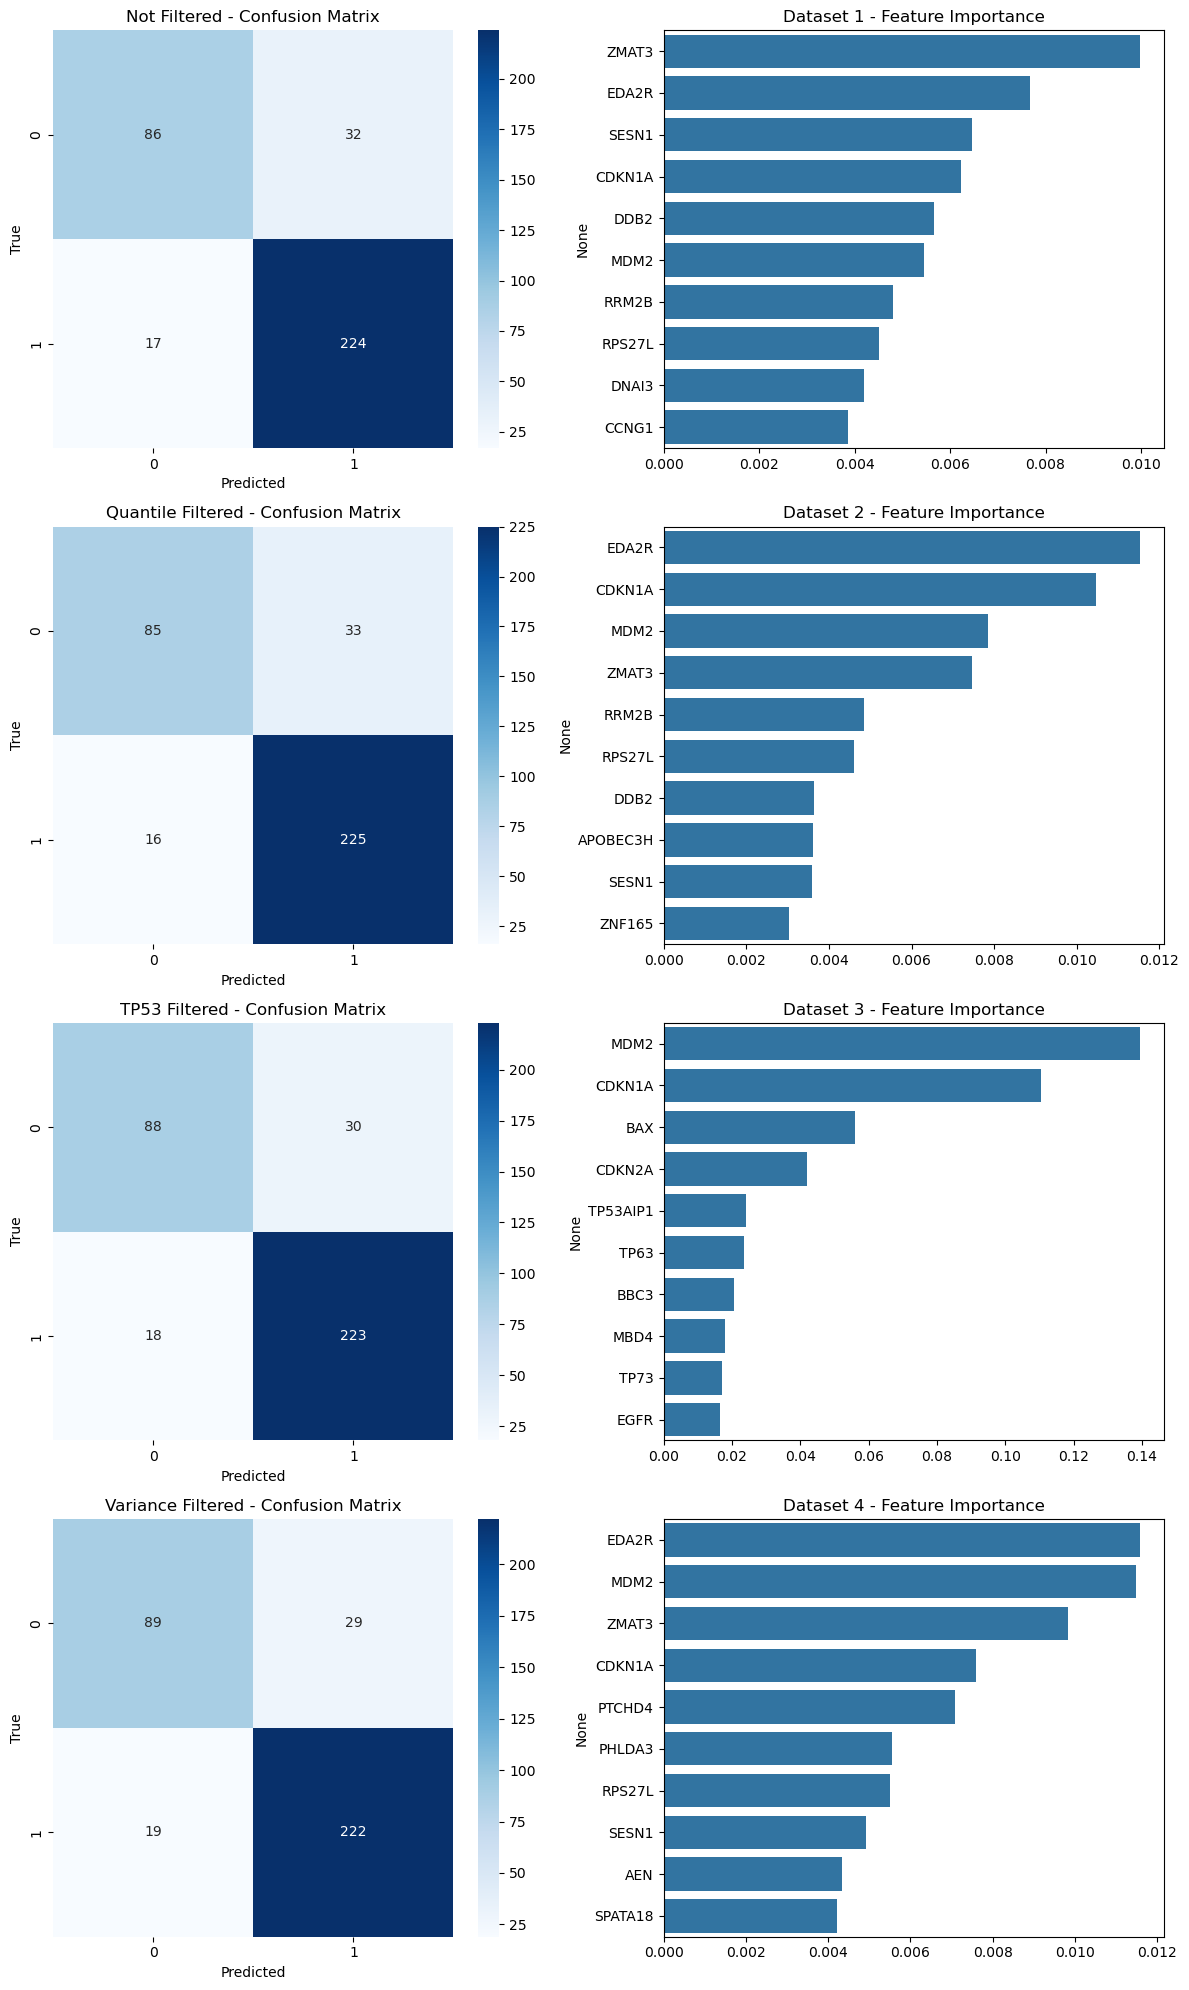

In [19]:
train_and_evaluate_on_datasets(datasets, 'random_forest')

# XGBoost

Not Filtered - Accuracy: 0.88 - F1 Score: 0.88 - Model: xgboost
Quantile Filtered - Accuracy: 0.87 - F1 Score: 0.87 - Model: xgboost
Quantile Filtered - Accuracy: 0.87 - F1 Score: 0.87 - Model: xgboost
TP53 Filtered - Accuracy: 0.87 - F1 Score: 0.87 - Model: xgboost
TP53 Filtered - Accuracy: 0.87 - F1 Score: 0.87 - Model: xgboost
Variance Filtered - Accuracy: 0.89 - F1 Score: 0.88 - Model: xgboost
Variance Filtered - Accuracy: 0.89 - F1 Score: 0.88 - Model: xgboost


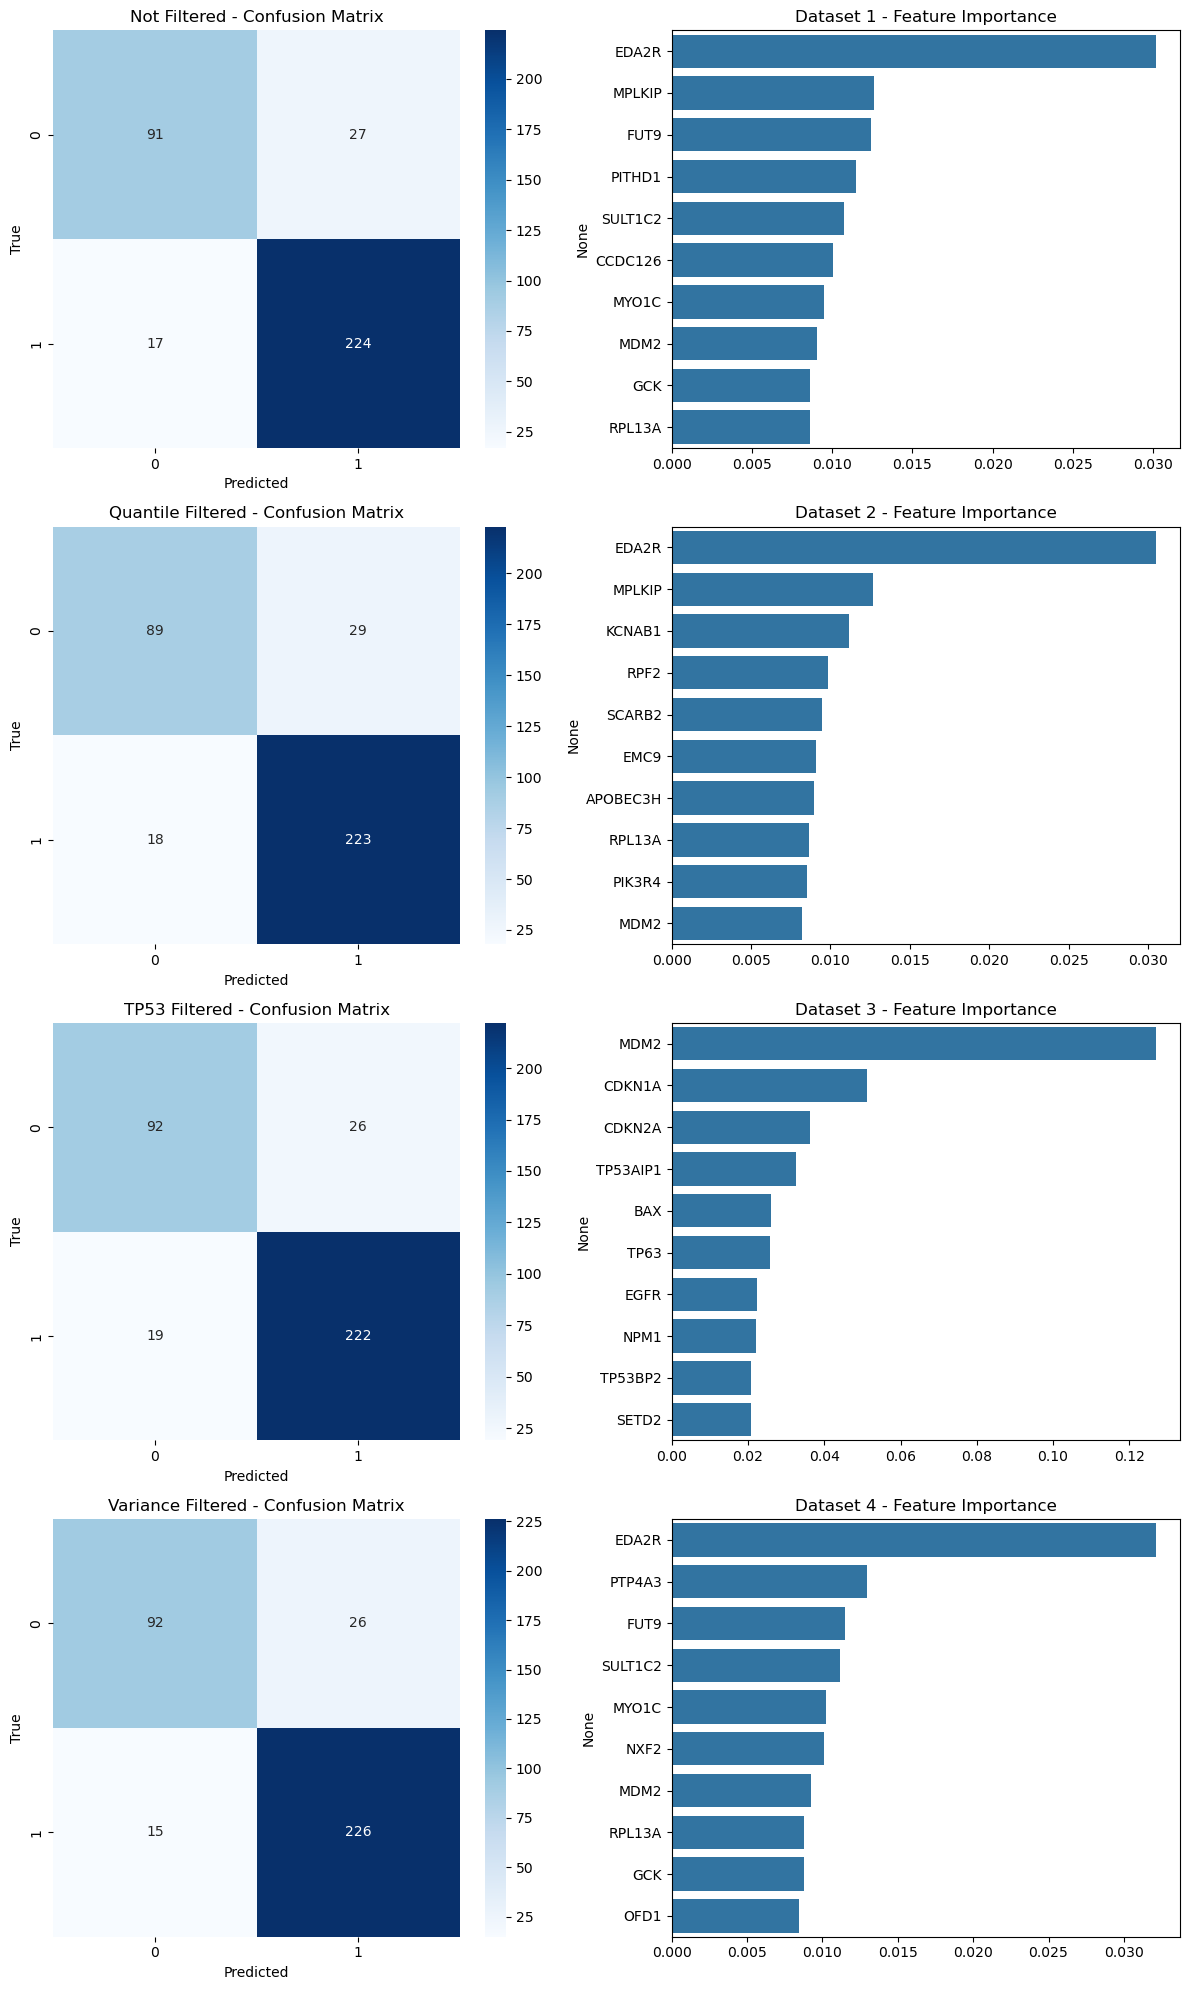

In [21]:
train_and_evaluate_on_datasets(datasets, 'xgboost')